# Домашнее задание - линейная регрессия

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import (MinMaxScaler, QuantileTransformer, RobustScaler)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (LinearRegression, RidgeClassifier, ElasticNet, LogisticRegression, SGDClassifier, PassiveAggressiveClassifier)

### Работа с признаками (8 баллов)

Скачайте датасет из материалов к уроку или по ссылке https://raw.githubusercontent.com/jupiterzhuo/travel-insurance/master/travel%20insurance.csv 


Описание признаков:

* Agency — название страхового агентства
* Agency Type — тип страхового агентства
* Distribution Channel — канал продвижения страхового агентства
* Product Name — название страхового продукта
* Duration — длительность поездки (количество дней)
* Destination — направление поездки
* Net Sales — сумма продаж 
* Commission (in value) — комиссия страхового агентства
* Gender — пол застрахованного
* Age — возраст застрахованного

Ответ:
* Claim — потребовалась ли страховая выплата: «да» — 1, «нет» — 0

Обработайте пропущенные значения и примените написанные функции onehot_encode() и minmax_scale().

**Подсказка**: маску для категориальных признаков можно сделать фильтром cat_features_mask = (df.dtypes == "object").values

#### Открытие DataFrame 

In [2]:
df = pd.read_csv('travel insurance.csv')

#### Обработка выбросов и создание нормального распределения

In [3]:
float_features_mask = (df.dtypes != "object").values
float_columns = df.columns[float_features_mask]
print(df.dtypes, float_features_mask)

scaler1 = MinMaxScaler(feature_range=(-1, 1))  # Bad
scaler2 = RobustScaler(quantile_range=(25, 75))  # Norm
scaler3 = QuantileTransformer(output_distribution="uniform", random_state=42)  # Better
scaler4 = QuantileTransformer(output_distribution="normal", random_state=42)  # Best

main_scaler = scaler4
for col in float_columns:
    # print(df[col], np.min(df[col]), np.mean(df[col]), np.max(df[col]))
    df[col] = main_scaler.fit_transform(np.reshape(df[col], [-1, 1]))
    # print(df[col], np.min(df[col]), np.mean(df[col]), np.max(df[col]))

Agency                   object
Agency Type              object
Distribution Channel     object
Product Name             object
Claim                    object
Duration                  int64
Destination              object
Net Sales               float64
Commision (in value)    float64
Gender                   object
Age                       int64
dtype: object [False False False False False  True False  True  True False  True]


#### Доработка и оптимизация фрейма

In [4]:
# Перевод колонки ответа на нужный тип данных
df['Claim'] = np.where(df['Claim'] == 'Yes', 1, 0)

# Удаление колонки, т.к. слишком много занчений для OneHotEncoding
# Это практически не отражается на точности и сильно `облегчает` модель (~4 раза меньше параметров объекта)
# print(df.nunique())
df = df.drop(columns=["Destination"])
print(df.nunique())

Agency                    16
Agency Type                2
Distribution Channel       2
Product Name              26
Claim                      2
Duration                 453
Net Sales               1134
Commision (in value)    1032
Gender                     2
Age                       89
dtype: int64


Анализ корреляции числовых признаков

In [5]:
df.corr(min_periods=1, numeric_only=True)  # Корреляция с числовыми фичами

,Claim,Duration,Net Sales,Commision (in value),Age
Claim,1.000000,0.064987,0.103355,0.091077,-0.021841
Duration,0.064987,1.000000,0.317339,0.099532,-0.035039
Net Sales,0.103355,0.317339,1.000000,0.203336,0.042432
Commision (in value),0.091077,0.099532,0.203336,1.000000,0.161464
Age,-0.021841,-0.035039,0.042432,0.161464,1.000000


#### Создание OneHotEncoding

In [6]:
cat_features_mask = (df.dtypes == "object").values
df = pd.get_dummies(df, prefix=df.columns[cat_features_mask], dummy_na=True, dtype=float)
print(df.dtypes, cat_features_mask)

Claim                                                  int32
Duration                                             float64
Net Sales                                            float64
Commision (in value)                                 float64
Age                                                  float64
Agency_ADM                                           float64
Agency_ART                                           float64
Agency_C2B                                           float64
Agency_CBH                                           float64
Agency_CCR                                           float64
Agency_CSR                                           float64
Agency_CWT                                           float64
Agency_EPX                                           float64
Agency_JWT                                           float64
Agency_JZI                                           float64
Agency_KML                                           float64
Agency_LWC              

Подробный анализ и подготовка датасета часто помогают улучшить качество модели. Ниже представлено несколько идей преобразований. Вы можете применить одно или несколько из этих преобразований (а можете не применять), чтобы помочь будущей модели. 

1. Посмотрите на количественные признаки. Возможно, в некоторых признаках есть выбросы - значения, которые сильно выбиваются. Такие значения полезно удалять. Советуем присмотреться к колонке Duration)

2. Можно заметить, что one hot encoding сильно раздувает количество столбцов. Радикальное решение - можно попробовать выбросить все категориальные признаки из датасета.

3. Если все-таки оставляете категориальные признаки, то подумайте, как уменьшить количество столбцов после one hot encoding. Признаки с большим количеством значений (Duration - 149! разных стран) можно удалить или попробовать сгруппировать некоторые значения.

4. Downsampling. Датасет достаточно большой, разница в классах огромная. Можно уменьшить число наблюдений с частым ответом.

#### Иследование распределений

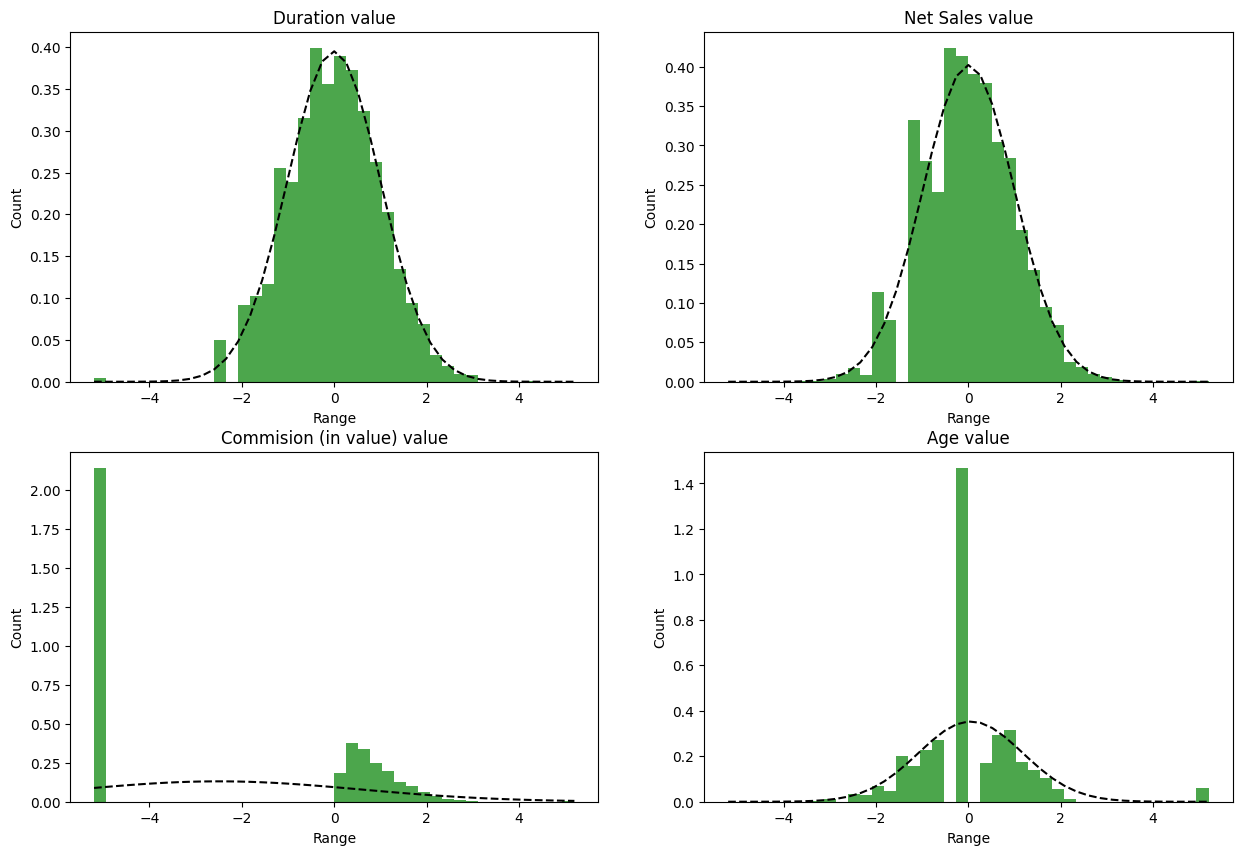

In [6]:
num_bins = 40

fig = plt.figure(figsize=(15, 10))
plot_count = 1
for col in float_columns:
    plt.subplot(2, 2, plot_count)
    n, bins, patches = plt.hist(df[col], num_bins, range=(np.min(df[col]), np.max(df[col])),
                                density=True, color='green', alpha=0.7)
    
    mu, sigma = np.mean(df[col]), np.std(df[col])
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    
    plt.plot(bins, y, '--', color ='black')
    plt.xlabel(f'Range')
    plt.ylabel(f'Count')
    plt.title(f'{col} value')
    plot_count += 1

plt.show()
# print(df.nunique())

Распределения (в основном) получились близки к нормальному распределению. Не идеально (можно было разбить выбросы значения в нижних графиках), но для данного примера вполне достаточно

Исследование итоговой корреляции в датафрейме

In [14]:
print(df.corr(method='pearson', min_periods=1, numeric_only=True)['Claim'])  # Корреляция method={‘pearson’, ‘kendall’, ‘spearman’}

Claim                                                1.000000
Duration                                             0.064987
Net Sales                                            0.103355
Commision (in value)                                 0.091077
Age                                                 -0.021841
Agency_ADM                                          -0.004389
Agency_ART                                          -0.007012
Agency_C2B                                           0.166248
Agency_CBH                                          -0.001577
Agency_CCR                                           0.000381
Agency_CSR                                          -0.000924
Agency_CWT                                          -0.015213
Agency_EPX                                          -0.084415
Agency_JWT                                          -0.008470
Agency_JZI                                          -0.027026
Agency_KML                                           0.003791
Agency_L

### Применение линейной регрессии (10 баллов)

Это задача классификации, но её можно решить с помощью линейной регрессии, если округлять предсказанный ответ до целого и выбирать ближайший по значению ответ из множества {0, 1}.

Вынесите признак 'Claim' в вектор ответов и разделите датасет на обучающую и тестовую выборку в соотношении 80 к 20. Зафиксируйте random_state.

**Подсказка:** быстро перевести Yes/No в 1/0 можно так - np.where(df['Claim'] == 'Yes', 1,0)

In [15]:
X = df[df.columns[np.where(df.columns != 'Claim')]]
y = df['Claim']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(df.shape, type(X), type(y))

(50660, 57) (12666, 57) (50660,) (12666,)
(63326, 58) <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


Найдите аналитическое решение для обучающей выборки: обычное и регуляризацией l2. 

In [16]:
# Расширение X_train
X_train_wide = np.hstack([np.ones((X_train.shape[0], 1)), X_train])

# Обычное аналитическое решение
alpha = 1e-9  #  Обычное, т.к. alpha ~ 0

W_ = np.linalg.inv(X_train_wide.T @ X_train_wide + alpha**2 * np.eye(X_train_wide.shape[1])) @ X_train_wide.T @ y_train
b, W = W_[0], W_[1:]
# print(X_train.shape, X_train_wide.shape)
# print(np.linalg.det(X_train_wide.T @ X_train_wide + alpha**2 * np.eye(X_train_wide.shape[1])))
# print(W_)

y_pred = X_train @ W + b
print(f"MSE train: {sklearn.metrics.mean_squared_error(y_train, y_pred) :.4f}")
print(f"MAE train: {sklearn.metrics.mean_absolute_error(y_train, y_pred) :.4f}")

MSE train: 0.1364
MAE train: 0.2387


In [17]:
# Аналитическое решение с регуляризацией
alpha = 1  #  L2, т.к. alpha = 1

W_ = np.linalg.inv(X_train_wide.T @ X_train_wide + alpha**2 * np.eye(X_train_wide.shape[1])) @ X_train_wide.T @ y_train
b, W = W_[0], W_[1:]
# print(X_train.shape, X_train_wide.shape)
# print(np.linalg.det(X_train_wide.T @ X_train_wide + alpha**2 * np.eye(X_train_wide.shape[1])))
# print(W_)

y_pred = X_train @ W + b
print(f"MSE train: {sklearn.metrics.mean_squared_error(y_train, y_pred) :.4f}")
print(f"MAE train: {sklearn.metrics.mean_absolute_error(y_train, y_pred) :.4f}")

y_pred = X_test @ W + b
print(f"MSE test: {sklearn.metrics.mean_squared_error(y_test, y_pred) :.4f}")
print(f"MAE test: {sklearn.metrics.mean_absolute_error(y_test, y_pred) :.4f}")

MSE train: 0.0140
MAE train: 0.0288
MSE test: 0.0135
MAE test: 0.0289


Постройте модель LinearRegression, примените к тестовой выборке и посчитайте MSE (можно использовать библиотеку sklearn)

In [28]:
model1 = LinearRegression()
model2 = ElasticNet()
model3 = RidgeClassifier(alpha=1.0, class_weight='balanced')
model4 = PassiveAggressiveClassifier(class_weight='balanced')
model5 = SGDClassifier(class_weight='balanced')
model6 = SGDClassifier(class_weight='balanced', loss='modified_huber')  # Best of all
model7 = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000)


model = model7
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_pred_int = np.where(y_pred < 0.5, 0, 1)
print(f"Model test MSE: {sklearn.metrics.mean_squared_error(y_test, y_pred) :.4f}")
print(f"Model test MAE: {sklearn.metrics.mean_absolute_error(y_test, y_pred) :.4f}")
print(f"Model test Precision: {sklearn.metrics.precision_score(y_test, y_pred_int) :.4f}")
print(f"Model test Recall: {sklearn.metrics.recall_score(y_test, y_pred_int) :.4f}")
print(f"Model test F1 score: {sklearn.metrics.f1_score(y_test, y_pred_int) :.4f}")

Model test MSE: 0.2185
Model test MAE: 0.2185
Model test Precision: 0.0473
Model test Recall: 0.7500
Model test F1 score: 0.0889


<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
(63326, 57) (63326,) (63326, 58) <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
[[ 1.64436854 -2.36229416  0.57459451  2.11266365  0.          0.
   0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.          0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]] [0]


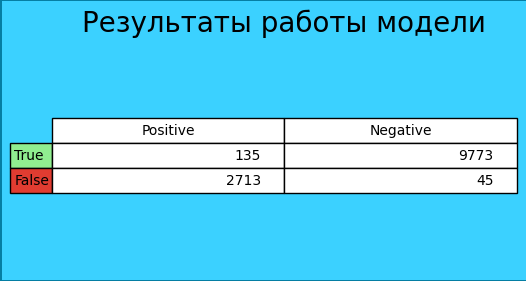

In [25]:
print(type(X), type(y))
print(X.shape, y.shape, df.shape, type(X), type(y))
print(X.values[:1], y.values[:1])

X_table, y_table = X_test, y_test  # X_train, y_train
y_pred = model.predict(X_table).reshape(-1)
y_pred = np.where(y_pred < 0.5, 0, 1)
y_pred_inv, y_table_inv = np.abs(y_pred - 1), np.abs(y_table - 1)

# Некрасивая реализация, т.к. раньше не додумался до:
# sklearn.metrics.confusion_matrix  tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
data = [
    [str(np.count_nonzero(np.logical_and(y_table     == y_pred,     y_table     == 1))),
     str(np.count_nonzero(np.logical_and(y_table_inv == y_pred_inv, y_table_inv == 1))),],
    [str(np.count_nonzero(np.logical_and(y_table     == y_pred_inv, y_table     == 0))),
     str(np.count_nonzero(np.logical_and(y_table_inv == y_pred,     y_table_inv == 0))),],
]

background_color = plt.cm.Blues(0.4)
plt.figure(figsize=(6, 3), linewidth=2,
           facecolor='#3bd1ff',
           edgecolor='#057ea3')

plt.title('Результаты работы модели', size=20)
table = plt.table(cellText=data,
          rowLabels=["True", "False"],
          colLabels=["Positive", "Negative"],
          rowColours=["lightgreen", "#E03C31"],
          loc='center')

table.scale(1, 1.5)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.figtext(0.95, 0.05, "", horizontalalignment='right', size=10, weight='light')

plt.show()
# plt.savefig("fname.png")

### Вывод (1 балла)

Напишите краткий вывод по заданию (достаточно пары предложений). Расскажите, какие способы предобработки данных вы выбрали и почему. Насколько хороша ваша модель?

В результате работы получилось изучить датасет, применить к нему _pd.get_dummies (one hot encoder)_ и создать более правильное распределение численных признаков _QuantileTransformer_ справился намного ~в разы~ лучше чем _MinMaxScaler_. Разделил датасет на выборки, применил к ним аналитическое решение, а также решение при помощи разных линейных моделей. _SGDClassifier(class_weight='balanced', loss='modified_huber')_ оказалась лучшим решением. Нашёл метрики к полученным решениям.